## **1. Import Libraries**

In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import re
import xgboost as xgb
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import joblib

## **2. Load and Info Data**

In [2]:
# Load dataset
#data = pd.read_csv('TRAINING_DATA.txt', names = ["labels", "text"], sep = "\t", header = None)

# Read the file line by line
# Use regex to split the label (first digit) and the text
# Append the cleaned data into a list
data_pre = []
with open('TRAINING_DATA.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Match a single digit at the beginning of the line followed by spaces and text
        match = re.match(r'^(\d)\s+(.*)$', line)
        if match:
            label, text = match.groups()
            # Append the label and text as a tuple
            data_pre.append((int(label), text.strip()))
# Convert the list into a DataFrame
data = pd.DataFrame(data_pre, columns=['labels', 'text'])


display(data.info(), type(data), data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17877 entries, 0 to 17876
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  17877 non-null  int64 
 1   text    17877 non-null  object
dtypes: int64(1), object(1)
memory usage: 279.5+ KB


None

pandas.core.frame.DataFrame

(17877, 2)

## **3. Put columns into variables**

In [3]:
# Divide into variables
X = data['text']
y = data['labels']

## **4. Cleaning Data**

In [4]:
# Removal of special character, stopwords
def removal(text): # Alex Code
    stop_words = set(stopwords.words('spanish')) # Spanish stopwords
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'\W', ' ', text)  # Remove everything that isn't a word or number

    words = text.split()  # Split for tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Process everything except the stopwords

    return ' '.join(words)

In [5]:
# Larry Code
def remove_accents_but_keep_ñ(text):
    # Replace accented vowels with their unaccented counterparts
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u',
        'Á': 'a', 'É': 'e', 'Í': 'i', 'Ó': 'o', 'Ú': 'u', 'Ü': 'u'
    }
    
    # Create a regex pattern for accented characters
    pattern = re.compile('|'.join(re.escape(char) for char in replacements.keys()))

    # Replace accented characters using the dictionary
    text = pattern.sub(lambda match: replacements[match.group(0)], text)
    return text

def normalize_text(text):
    # Step 1: Remove accents but keep "ñ"
    text = remove_accents_but_keep_ñ(text)

    # Step 2: Convert text to lowercase
    text = text.lower()

    # Step 3: Remove numbers
    text = re.sub(r'\d+', '', text)

    # Step 4: Remove special characters but keep letters, spaces, and "ñ"
    text = re.sub(r'[^a-zñ ]', '', text)

    # Step 5: Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [6]:
# Apply removal
X = X.apply(normalize_text)


#y = y.astype(int) # int64 to int32

## **5. Split Data into Training and Test**

In [7]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (12513,) (12513,)
Test set: (5364,) (5364,)


## **6. TF-IDF Vectorization**

In [8]:
# TF-IDF Vectorization
tf_idf_vectorizer = TfidfVectorizer() # TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)

X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)

X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

## **7. SVC Model and fitting**

In [9]:
# SVC Model
svc = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


svc.fit(X_train_tf_idf, y_train)

# svc = RandomForestClassifier() == 98.8, 0.32
# svc = SVC() = 0.88, 0.33
# svc = SVC(kernel = 'linear', random_state = 42) == 0.76, 0.40
# svc = MultinomialNB() == 0.79, 0.35
# LogisticRegression() == 0.75, 0.42
# svc = xgb.XGBClassifier() == 0.72, 0.46

# svc = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27) == 0.71, 0.47
# == 0.60, 0.50


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

## **8. Prediction**

In [10]:
# Predict
svc_train_pred = svc.predict(X_train_tf_idf)
svc_test_pred = svc.predict(X_test_tf_idf)

## **9. Accuracy Score**

In [26]:
# Accuracy Score
svc_train_accuracy = accuracy_score(y_train, svc_train_pred)
svc_test_accuracy = accuracy_score(y_test, svc_test_pred)

print("Train accuracy_score:", svc_train_accuracy)
print("Test accuracy_score:", svc_test_accuracy)

# Classification Report
print()
print("classification_report:\n", classification_report(y_test, svc_test_pred))

Train accuracy_score: 0.6084072564532885
Test accuracy_score: 0.5022371364653244

classification_report:
               precision    recall  f1-score   support

           0       0.49      0.51      0.50      2639
           1       0.51      0.49      0.50      2725

    accuracy                           0.50      5364
   macro avg       0.50      0.50      0.50      5364
weighted avg       0.50      0.50      0.50      5364



## **10. Graph**

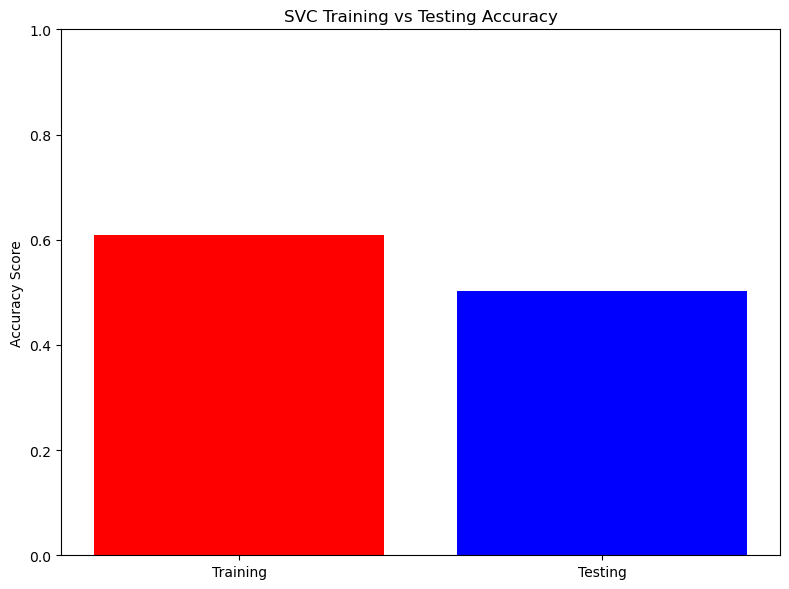

In [12]:
# Graphical Representation
plt.figure(figsize = (8, 6))
plt.bar(['Training', 'Testing'], [svc_train_accuracy, svc_test_accuracy], color=['red', 'blue'])
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.title('SVC Training vs Testing Accuracy')
plt.tight_layout()
plt.show()

## **11. Real Data**

In [13]:
# Load real data
real_data_pre = []

with open('REAL_DATA.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Match a single digit at the beginning of the line followed by spaces and text
        match = re.match(r'^(\d)\s+(.*)$', line)

        if match:
            label, text = match.groups()

            # Append the label and text as a tuple
            real_data_pre.append((int(label), text.strip()))

# Convert the list into a DataFrame
real_data = pd.DataFrame(real_data_pre, columns=['labels', 'text'])

display(real_data)


'''
# Load real data
real_data = pd.read_csv("REAL_DATA.txt", names = ["labels", "text"], sep = "\t", header = None)
print(real_data)
'''

# Preprocess the text
real_data['text'] = real_data['text'].apply(normalize_text)

# Transform the real data
real_X_tf_idf_vectorizer = tf_idf_vectorizer.transform(real_data['text'])

display(real_data)



,labels,text
0,2,Yo no creo que a nadie le haya encantado un pe...
1,2,No va a resolver sus problemas de crédito o me...
2,2,Te encantará este !
3,2,Yo estaba a volar a un aeropuerto varias horas...
4,2,"( Maid En Manhattan , The Wedding Planner , Je..."
...,...,...
2196,2,Robert Pattinson se está moviendo desde su ima...
2197,2,Era tan fresco !
2198,2,Al salir de la sala de ensayos de laboratorio ...
2199,2,"Bueno , si usted pensaba que no era bueno para..."


,labels,text
0,2,yo no creo que a nadie le haya encantado un pe...
1,2,no va a resolver sus problemas de credito o me...
2,2,te encantara este
3,2,yo estaba a volar a un aeropuerto varias horas...
4,2,maid en manhattan the wedding planner jersey g...
...,...,...
2196,2,robert pattinson se esta moviendo desde su ima...
2197,2,era tan fresco
2198,2,al salir de la sala de ensayos de laboratorio ...
2199,2,bueno si usted pensaba que no era bueno para m...


## **12. Real Data Prediction and Labeling**

In [14]:
# Predict if its 1 or 0
predicted_labels = svc.predict(real_X_tf_idf_vectorizer)

# Map numerical predictions to classes
label_mapping = {0: "Machine", 1: "Human"}
real_data['predicted_label'] = pd.Series(predicted_labels).map(label_mapping)

# Assign the new labels
real_data['labels'] = predicted_labels

'''# Add additional column
real_data.insert(
    real_data.columns.get_loc('text') + 1, 
    'predicted_label',                 
    real_data.pop('predicted_label') 
)'''

# Save the updated dataframe
real_data_path = 'G3_labeled_data.txt'
real_data.to_csv(real_data_path, index = False)



## **13. Graph Real Data**

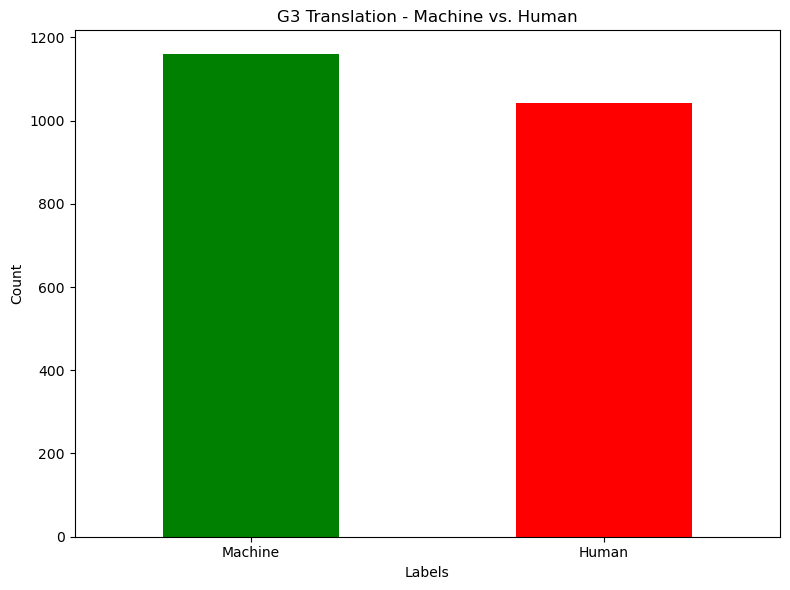

predicted_label
Machine    1159
Human      1042
Name: count, dtype: int64


In [15]:
# Plot
label_counts = real_data['predicted_label'].value_counts()

plt.figure(figsize = (8, 6))

label_counts.plot(kind = 'bar', color = ['green', 'red'])

plt.title('G3 Translation - Machine vs. Human')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

# Show counts
print(label_counts)

In [16]:
real_data = pd.read_csv("G3_labeled_data.txt", names = ["labels", "text", "predicted"], sep = ",", header = None, encoding = 'utf-8')

display(real_data)

,labels,text,predicted
0,labels,text,predicted_label
1,1,yo no creo que a nadie le haya encantado un pe...,Human
2,0,no va a resolver sus problemas de credito o me...,Machine
3,1,te encantara este,Human
4,0,yo estaba a volar a un aeropuerto varias horas...,Machine
...,...,...,...
2197,1,robert pattinson se esta moviendo desde su ima...,Human
2198,0,era tan fresco,Machine
2199,0,al salir de la sala de ensayos de laboratorio ...,Machine
2200,0,bueno si usted pensaba que no era bueno para m...,Machine


In [17]:
joblib.dump(svc, 'G3_model.joblib')

# loaded_model = joblib.load('G3_model.joblib')

['G3_model.joblib']